<a href="https://colab.research.google.com/github/francoisdoanp/MLTBP/blob/master/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning - Final Project**

# Turbofan engine degradation dataset (NASA)

# Data Preparation

**Importing necessary packages**



In [0]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from sklearn.preprocessing import PolynomialFeatures

**Importing the Turbofan engine degradation dataset.**

**Files are located in the following Github repository: https://github.com/francoisdoanp/MLTBP**

We have 4 training datasets, which contains information about one hundred engines, all of the same type. Thus, we will combine the training and test data sets. 

The training and test sets have 21 columns: ID, Time (Cycles), 3 columns for operational settings and 21 sensor measurements.

The training and testing sets have the same format, while the validation sets only contain the real RUL (remaining useful life).

For more information on the data, consult the read me at the following address:https://github.com/francoisdoanp/MLTBP/blob/master/readme.txt

In [0]:
url_base = 'https://raw.githubusercontent.com/francoisdoanp/MLTBP/master/'

file_train_1 = 'train_FD001.txt'
file_train_2 = 'train_FD002.txt'
file_train_3 = 'train_FD003.txt'
file_train_4 = 'train_FD004.txt'

file_test_1 = 'test_FD001.txt'
file_test_2 = 'test_FD002.txt'
file_test_3 = 'test_FD003.txt'
file_test_4 = 'test_FD004.txt'

file_valid_1 = 'RUL_FD001.txt'
file_valid_2 = 'RUL_FD002.txt'
file_valid_3 = 'RUL_FD003.txt'
file_valid_4 = 'RUL_FD004.txt'


pt1 = pd.read_csv(url_base + file_train_1, sep=' ', header=None)
pt2 = pd.read_csv(url_base + file_train_2, sep=' ', header=None)
pt3 = pd.read_csv(url_base + file_train_3, sep=' ', header=None)
pt4 = pd.read_csv(url_base + file_train_4, sep=' ', header=None)

pte1 = pd.read_csv(url_base + file_test_1, sep=' ', header=None)
pte2 = pd.read_csv(url_base + file_test_2, sep=' ', header=None)
pte3 = pd.read_csv(url_base + file_test_3, sep=' ', header=None)
pte4 = pd.read_csv(url_base + file_test_4, sep=' ', header=None)

pv1 = pd.read_csv(url_base + file_valid_1, header=None)
pv2 = pd.read_csv(url_base + file_valid_2, header=None)
pv3 = pd.read_csv(url_base + file_valid_3, header=None)
pv4 = pd.read_csv(url_base + file_valid_4, header=None)


# Updating ids

pt2[0] = pt2[0].apply(lambda x: x+100)
pt3[0] = pt3[0].apply(lambda x: x+360)
pt4[0] = pt4[0].apply(lambda x: x+460)

pte2[0] = pte2[0].apply(lambda x: x+100)
pte3[0] = pte3[0].apply(lambda x: x+359)
pte4[0] = pte4[0].apply(lambda x: x+459)


# Joining the dataframes

train_pd = pd.concat([pt1,pt2,pt3,pt4])
test_pd = pd.concat([pte1,pte2,pte3,pte4])
valid_pd = pd.concat([pv1,pv2,pv3,pv4], ignore_index=True)

train_pd = train_pd.drop(train_pd.columns[[26,27]], axis='columns')
test_pd = test_pd.drop(test_pd.columns[[26,27]], axis='columns')


# Assigning labels to Dataframe's columns based on the Readme

train_pd.columns = ['id', 'Time (Cycles)', 'OS1', 'OS2', 'OS3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
test_pd.columns = ['id', 'Time (Cycles)', 'OS1', 'OS2', 'OS3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
valid_pd.columns = ['RUL']

#Loading scaler

scaler = MinMaxScaler()
  

**Adding variables Conditons and fault mode**

Note:

**Condition (ONE)** and **Fault ONE** are binary variables.

When Condition(ONE) = 1 (true), it means that the condition is at Sea Level

When Condition(ONE) = 0 (false), it means NO, the condition IS NOT AT SEA LEVEL, and thus is the  second condition; SIX.

When Fault ONE = 1 (true), it means that the fault modes is one (HPC Degradation)

When Fault ONE = 0 (false), it means that the fault mode is TWO (HPC Degradation and Fan degradation)

In [30]:
# Adding variables Condition and fault modes

def value_condition_train(row):
  if (row['id'] <= 100):
    return 1
  elif (row['id'] <= 360) & (row['id'] > 100):
    return 0
  elif (row['id'] <= 460) & (row['id'] > 360):
    return 1
  else:
    return 0
  
def value_fault_train(row):
  if (row['id'] <= 100):
    return 1
  elif (row['id'] <= 360) & (row['id'] > 100):
    return 1
  elif (row['id'] <= 460) & (row['id'] > 360):
    return 0
  else:
    return 0
  
def value_condition_test(row):
  if (row['id'] <= 100):
    return 1
  elif (row['id'] <= 359) & (row['id'] > 100):
    return 0
  elif (row['id'] <= 459) & (row['id'] > 359):
    return 1
  else:
    return 0
  
def value_fault_test(row):
  if (row['id'] <= 100):
    return 1
  elif (row['id'] <= 359) & (row['id'] > 100):
    return 1
  elif (row['id'] <= 459) & (row['id'] > 359):
    return 0
  else:
    return 0


train_pd['Condition (One)'] = train_pd.apply(value_condition_train, axis=1)
train_pd['Fault ONE'] = train_pd.apply(value_fault_train,axis=1)

test_pd['Condition (One)'] = test_pd.apply(value_condition_test, axis=1)
test_pd['Fault ONE'] = test_pd.apply(value_fault_test,axis=1)

display(train_pd)

,id,Time (Cycles),OS1,OS2,OS3,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,Condition (One),Fault ONE
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.30,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,1
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.30,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,1
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.30,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1,1
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.30,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1,1
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.30,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,709,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,404.59,2319.66,8840.16,1.27,46.08,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,0,0
61245,709,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,567.59,2388.47,9117.12,1.31,48.04,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,0,0
61246,709,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,569.04,2388.51,9126.53,1.31,48.24,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,0,0
61247,709,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,199.93,2223.78,8403.64,1.05,42.53,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,0,0


At this stage, we create the truth remaining useful life (RUL) for the training set.

Important note: In the training set, the last Cycle (represented in the table by 'Time (Cycles)') is when the engine is considered unusable. However, in the test set, the last cycle IS NOT when the engine is considered unusable. It will fail at a later time. Thus, in the valid_pd, we have the true RUL. 

In [0]:
#Adding column for remaining useful life (RUL)

y_train = pd.DataFrame(train_pd.groupby(['id'])['Time (Cycles)'].max())

train_pd = pd.merge(train_pd,y_train, on='id')
train_pd['RUL'] = train_pd['Time (Cycles)_y'] - train_pd['Time (Cycles)_x']
train_pd = train_pd.drop('Time (Cycles)_y',1)
train_pd = train_pd.rename(columns = {'Time (Cycles)_x':'Time (Cycles)'})

y_train = train_pd.iloc[:,28]


In [0]:
def model_score(y_true, y_pred):
  pred_df = pd.DataFrame(y_pred)
  test_err = pd.concat([y_true,pred_df], axis=1)
  test_err.columns = ['RUL', 'Pred_RUL']
  a1 = 10
  a2 = 13
  score=0

  for index, row in test_err.iterrows():
    d = row['Pred_RUL'] - row['RUL']
    if d < 0:
      score += np.expm1(-(d/a1))
    else:
      score += np.expm1(d/a2)

  return score


# Data Exploration

**Now that we have our data, we can get to know our dataset**

In [7]:
display(train_pd.head())

display(test_pd)


print(f'The training dataset contains {train_pd.shape[0]} rows.')


,Unit Number,Time (Cycles),OS1,OS2,OS3,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,Condition (One),Fault ONE,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,1,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,1,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1,1,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1,1,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1,1,187


,Unit Number,Time (Cycles),OS1,OS2,OS3,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,Condition (One),Fault ONE
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.30,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,1,1
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.30,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,1,1
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.30,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,1,1
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.30,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,1,1
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.30,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,707,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,5.72,138.34,2212.35,8351.73,1.02,42.30,130.87,2388.50,8112.61,9.4427,0.02,331,2212,100.0,10.53,6.2620,0,0
41210,707,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,13.66,334.75,2324.23,8758.69,1.07,44.53,314.51,2388.33,8086.83,9.2772,0.02,366,2324,100.0,24.33,14.6486,0,0
41211,707,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,8.00,194.92,2223.57,8370.49,1.02,42.33,182.76,2388.64,8100.84,9.3982,0.02,336,2223,100.0,14.69,8.8389,0,0
41212,707,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,13.66,333.15,2324.19,8753.04,1.07,44.78,314.17,2388.37,8085.24,9.2727,0.03,366,2324,100.0,24.44,14.6887,0,0


The training dataset contains 160359 rows.


In [0]:
# Print out a table with count, mean, std, min, max, 25%, 50%, 75%

print(train_pd.describe())

**Exploring the effects of sensors on RUL**



In [0]:


print(sns.heatmap(train_pd.corr(), annot=True, cmap='RdYlGn'))

train_pd.corr()

In [0]:
print()

**Exploring correlation between variables**

In [0]:
corr = train_pd.groupby(['RUL']).corr()
corr.style.background_gradient(cmap='coolwarm')

**How do we know when an engine fails?**

We look at the last time cycle for every id.



Text(0, 0.5, 'Frequency')

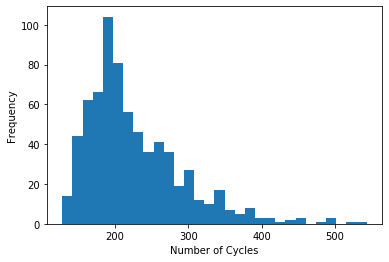

In [8]:
train_pd.groupby(['id'])['Time (Cycles)'].max().hist(bins=30, grid=False)
plt.xlabel('Number of Cycles')
plt.ylabel('Frequency')


#**Model 1: Multiple Linear Regression**






**Preparing data**

In [33]:
# Scaling data

train_pd_scaled = train_pd.copy()
train_pd_scaled.iloc[:,1:26] = scaler.fit_transform(train_pd.iloc[:,1:26])

test_pd_lm = test_pd.copy()
test_pd_lm.iloc[:,1:26] = scaler.fit_transform(test_pd.iloc[:,1:26])

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)

print(train_pd_scaled)


         id  Time (Cycles)       OS1       OS2  OS3        S1        S2  \
0       1    0.000000       0.000190  0.000237  1.0  1.000000  0.969990   
1       1    0.001845       0.000252  0.000356  1.0  1.000000  0.973000   
2       1    0.003690       0.000105  0.001068  1.0  1.000000  0.974824   
3       1    0.005535       0.000224  0.000712  1.0  1.000000  0.974824   
4       1    0.007380       0.000162  0.000475  1.0  1.000000  0.975007   
...    ..         ...            ...       ...  ...       ...       ...   
160354  709  0.461255       0.238203  0.297413  1.0  0.597937  0.637143   
160355  709  0.463100       0.000274  0.002492  1.0  1.000000  0.984585   
160356  709  0.464945       0.000276  0.000712  1.0  1.000000  0.986956   
160357  709  0.466790       0.833319  0.997626  1.0  0.060269  0.185077   
160358  709  0.468635       0.999881  0.997626  1.0  0.000000  0.131077   

              S3        S4        S5        S6        S7        S8        S9  \
0       0.927293  0

In [0]:
# Removing RUL and id columns, as we do not want these features to be in our predictors

train_pd_lm = train_pd_scaled.copy()
train_pd_lm = train_pd_lm.drop(['RUL', 'id'],axis=1)

# Keeping only last time cycle for each id

idx = test_pd_lm.groupby(['id'])['Time (Cycles)'].transform(max) == test_pd_lm['Time (Cycles)']
test_pd_lm = test_pd_lm[idx]

# Removing id column

test_pd_lm = test_pd_lm.drop(['id'], axis=1)

**Fitting Linear Model (Not time sensitive)**

In [35]:
# Fitting Linear model

reg = LinearRegression().fit(train_pd_lm, y_train)

y_pred = reg.predict(test_pd_lm)

acc_score_lm =  metrics.mean_absolute_error(valid_pd, y_pred)

print(f'The mean absolute error for the linear model is: {(acc_score_lm)}.')


The mean absolute error for the linear model is: 36.92713782490115.


**Linear Model with interactions & Polynomial**



In [0]:
# The PolynomialFeatures transforms our dataset to include ALL interactions and ALL variables^2.

lm_poly_int = PolynomialFeatures(2)
train_pd_lm_poly = lm_poly_int.fit_transform(train_pd_lm)

reg_poly = LinearRegression().fit(train_pd_lm_poly,y_train)

In [37]:
test_pd_lm_poly = lm_poly_int.fit_transform(test_pd_lm)

y_pred_poly = reg_poly.predict(test_pd_lm_poly)

acc_score_lm_poly =  metrics.mean_absolute_error(valid_pd, y_pred_poly)

print(f'The mean absolute error for the linear model is: {(acc_score_lm_poly)}.')

# We conclude that there is probabily high colinearity in the variables, so a model including interactions would not help much.

The mean absolute error for the linear model is: 37.99369274608822.


#**Model 3: Recurrent Neural Networks with LSTM architecture**

In [38]:
# Using Azure tutorial for predictive maintenance for data manipulation
# Reference: https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

# Picking a sequence length - This will be the window of time in which the LSTM will gather data from

sequence_length = 50


# This function will reshape our data so it can be usable with Keras (Samples, time window, features)
def gen_sequence(id_df, seq_length,seq_cols):
  data_array = id_df[seq_cols].values
  num_elements = data_array.shape[0]
  for start,stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
    yield data_array[start:stop,:]

# Reference column names

sensor_cols = ['S' + str(i) for i in range(1,22)]
sequence_cols = ['Time (Cycles)', 'OS1', 'OS2', 'OS3']
other_cols = ['Condition (One)', 'Fault ONE']
sequence_cols.extend(sensor_cols)
sequence_cols.extend(other_cols)

# Generating sequences

seq_gen = (list(gen_sequence(train_pd_scaled[train_pd_scaled['id']==id], sequence_length,sequence_cols))
          for id in train_pd_scaled['id'].unique())

# Generate sequences and convert to numpy array

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

def gen_labels(id_df, seq_length, label):
  data = id_df[label].values
  num_elements = data.shape[0]
  return data[seq_length:num_elements,:]

label_gen = [gen_labels(train_pd_scaled[train_pd_scaled['id']==id], sequence_length, ['RUL'])
            for id in train_pd_scaled['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(124909, 50, 27)
(124909, 1)


In [43]:
print(label_array.shape[1])

1


In [50]:
# Building the RNN

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(units=nb_out))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])

print(model.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 50, 100)           51200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 131,701
Trainable params: 131,701
Non-trainable params: 0
________________________________________________